# Interpretability analysis of SHAP predicted by machine learning models for CO<sub>2</sub> adsorption

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import shap
display.set_matplotlib_formats('svg')


`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Data Import and model training

In [11]:
# Data import
df_data = pd.read_csv(r'data\CURATEDCOFs_CO2.csv')
tpot_data = df_data.drop('COFs_name',axis=1)
features_all = tpot_data.drop(labels=['LCD(Å)','TE','N_CO2(mol/kg)','D_CO2(10^-8 m2/s)','P_CO2(10^4 Barrer)'],axis=1)

# Model training
training_features, testing_features, training_target, testing_target = \
            train_test_split(features_all, tpot_data['N_CO2(mol/kg)'],test_size=0.2, random_state=42)

exported_pipeline = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="huber", max_depth=5, max_features=1.0, min_samples_leaf=2, min_samples_split=18, n_estimators=100, subsample=0.7000000000000001)
exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
y_pred_train = exported_pipeline.predict(training_features)

# SHAP analysis

In [12]:
# In the Jupyter-notebook environment, load the JS code for visualization
shap.initjs()  

# Depending on the machine learning model, the tree-based model interpreter is selected
# explainer = shap.Explainer(exported_pipeline,training_features)
explainer = shap.TreeExplainer(exported_pipeline)

# Pass in the feature matrix X and calculate the SHAP value.
# shap_value2 is used to accurately calculate feature contribution values.
shap_values = explainer.shap_values(training_features)  
shap_values2 = explainer(training_features)

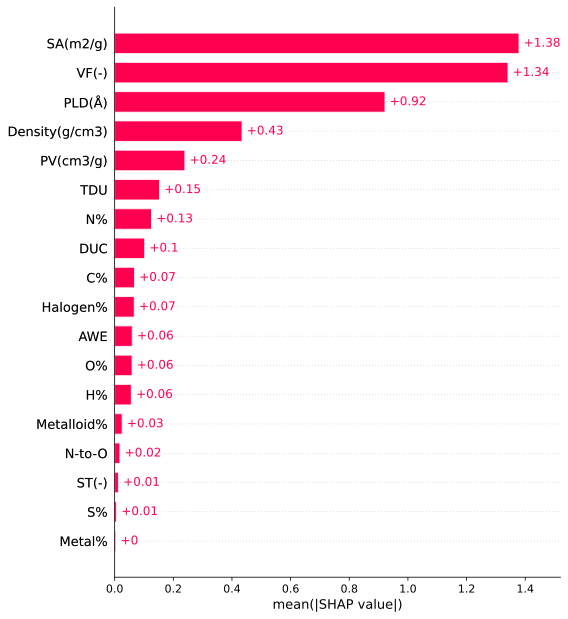

In [13]:
# Calculate the global feature contribution value
shap.plots.bar(shap_values2,max_display=18)

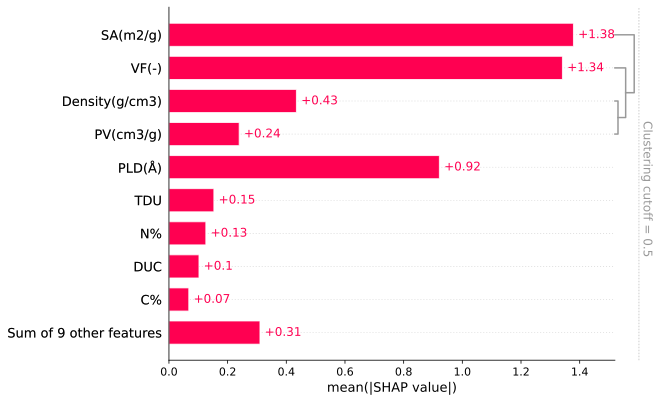

In [14]:
# Feature redundancy is calculated using feature clustering
clustering = shap.utils.hclust(training_features, y_pred_train) 
shap.plots.bar(shap_values2, 
               clustering=clustering,
               clustering_cutoff=0.5)

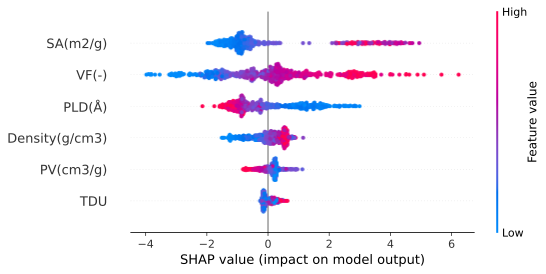

In [15]:
# Ranking of feature contributions to distinguish positive and negative effects
'''
On the vertical axis, the features are sorted by the sum of SHAP values for all samples, 
and on the horizontal axis, the SHAP values (the distribution of the influence of the feature on the model output);
Each dot represents a sample, the sample size is stacked vertically, 
and the color represents the feature values (red for high values, blue for low values).
'''
shap.summary_plot(shap_values, training_features,max_display=6)


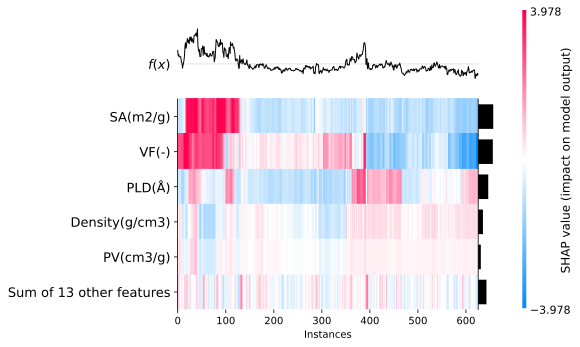

In [16]:
# Heatmap plot
'''
Heatmaps aim to show the overall substructure of a dataset using supervised clustering and heatmaps. 
Supervised clustering involves clustering data points not by their raw feature values but by their shap values.
'''
shap.plots.heatmap(shap_values2,max_display=6)

In [17]:
# The Top N eigenvalues and the corresponding SHAP values of a single sample are obtained
def get_topN_reason(old_list, features, top_num = 3, min_value = 0.0):
  # The N labels with the highest shap value are output
  feature_importance_dict = {}
  for i, f in zip(old_list, features):
    feature_importance_dict[f] = i
  new_dict = dict(sorted(feature_importance_dict.items(), key=lambda e: e[1], reverse=True))
  return_dict = {}
  for k ,v in new_dict.items():
    if top_num > 0:
      if v >= min_value:
        return_dict[k] = v
        top_num -= 1
      else:
        break
    else:
      break
  return return_dict
# Here we pick the first sample, and you are free to choose any sample you want
print(get_topN_reason(old_list=shap_values[1], features=training_features.columns.values)) 

{'VF(-)': 1.8962803384529954, 'N%': 0.30171758095158546, 'TDU': 0.15499602831204}
